<a href="https://colab.research.google.com/github/VDR-ACJ/EY_DIO_FAST_TRACK_ML/blob/main/recognition_speech_valdeir_Jesus_EY_DIO_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sistema de reconhecimento de fala para consulta na internet** 

Resumo: Converte audio captado do microfone em texto, busca o termo na internet(via site do Google), e retorna a "descrição" da pagina pesquisada "se estiver disponível" em audio e abre a pagina pesquisada para navegação;



*Steps*:

1. Após executar o codigo habilitar o uso do microfone e pop-up no navagador;
2. Quando começar a gravação fale o que deseja consultar;
3. Clique no botão concluir quando terminar de falar e aguarde o retorno


*A biblioteca **BeautifulSoup** foi utilizada para extrair dados de uma pagina da internet.

https://pypi.org/project/beautifulsoup4/
https://medium.com/pyladiesbh/beautiful-soup-parseamento-de-html-337197a7d4b9

*Abertura de link via javascript em uma nova aba.

https://stackoverflow.com/questions/34446172/open-url-in-new-tab-from-ipython-notebook-jupyter-cell

*Para captar o audio foi necessário chamar um método javascript porque a biblioteca pyaudio não consegue acessar o microfone da maquina local nativamente devido estar rodando em um ambiente virtua, neste caso o colab.

https://stackoverflow.com/questions/67709421/how-to-transcribe-the-recording-for-speech-recognization

Imagem de referência do resumo que o site do google disponibiliza para a maioria das pesquisas efetuadas no site. Através da biblioteca BeautifulSoup é possível gerar um arquivo html ou xml desta página para extrair os dados.

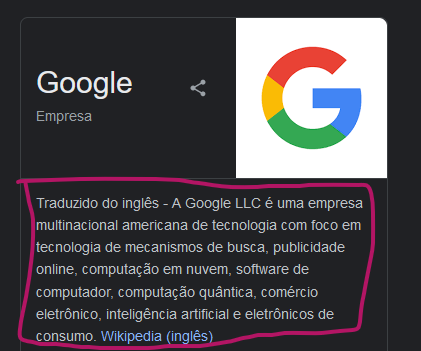

In [163]:
!pip install SpeechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [164]:
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* Foi necessário instalar as bibliotecas abaixo antes de instalar o pyaudio

In [165]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [166]:
!pip install pyaudio
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import time

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Gravando... click aqui para concluir.";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);

recordButton.style = "padding:20px"
recordButton.style.backgroundColor = "lightseagreen"
recordButtonfontSize  = "20px"

function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Processando... aguarde!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  resolve(base64data.toString())

});

}
});
      
</script>
"""

#Metodo para captar audio via javascript porque a biblioteca pyaudio não consegue acessar o microfone da maquina local nativamente
def get_audio_b():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  time.sleep(5)
  return output

In [168]:
from gtts import gTTS
#Metodo para criar o arquivo de audio
def texto_resposta(resposta: str):
  language = "pt"
  gtts_object = gTTS(text = resposta, 
                    lang = language,
                    slow = False)
  fileName = "/content/gtts.wav"
  gtts_object.save(fileName)
  return fileName

In [169]:
import webbrowser
from IPython.display import Javascript

# Abre o site em uma nova aba do navegador atrvés da url informada
def abrir_site(url : any):
  display(Javascript('window.open("{url}");'.format(url=url)))
   

In [170]:
import requests, lxml
import json
from bs4 import BeautifulSoup
#Verifica se o modulo foi carregado
try:
        from googlesearch import search
except ImportError:
      print("No module named 'google' found")
#Metodo retorna a descrição do item pesquisado disponível na consulta do site do google
def retorna_desc_site(texto: any):
    
  headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.19582",
        'Cache-Control': 'no-cache'
    }

  params = {
        "q": texto,#endereço do site
        "hl": "pt_br",#idioma
    }
  soup=""
  #Consulta pagina na internet e retorna em formato texto a pagina para extrair as informações
  html = requests.get("https://www.google.com.br/search", params=params, headers=headers)
  soup = BeautifulSoup(html.text, 'lxml')
  
  #verifica através da classe e posição a div correspondente ao conteúdo de resumo da pesquisa se encontrado
  if soup.find_all('div', class_='BNeawe s3v9rd AP7Wnd')[7].get_text() is not None:
    retorno = (soup.find_all('div', class_='BNeawe s3v9rd AP7Wnd')[7].get_text())
  else:
      retorno = "Infelizmente não foi possível trazer nenhuma informação, tente novamente"
  return retorno

In [171]:
def pesquisa_internet (texto : any):
  try:
      from googlesearch import search
  except ImportError:
      print("No module named 'google' found")  
  # Variavel query recebe o texto para pesquisa
  query = texto

  #Laço para retornar os resultados da pesquisa, neste caso esta limitado ao primeiro registro o link
  #for j in search(query, tld="co.in",lang="pt", num=10, stop=10, pause=2):
  for j in search(query, tld="com.br",lang="pt", num=1, stop=1, safe='on', pause=2):
      #print(j)
      if j is not None:
        abrir_site(j)
        valor = (retorna_desc_site(texto))
        print (valor)
      else:
        valor="Desculpe não consegui fazer a pesquisa"
      return valor

In [172]:
import speech_recognition as sr
import os
import time
#Função para identificar o comando de voz
def analiza_fala(wav: any):
    #Habilita o microfone do usuário / inicializa a classe
    recognizer = sr.Recognizer()

    try:

        #Configurações de propriedades do audio
        audio = sr.AudioData(wav, 44000, 2)
       
        #Metodo para transcrever a fala passando o audio e o idioma como paramêtros
        frase = recognizer.recognize_google(audio,language='pt-BR')
        #frase = recognizer.recognize_google(audio,language='en-US')

        #Transcreve a fala para exibição
        print("Closed Caption: " + frase)
        
        endereco_retorno = pesquisa_internet(frase)
        endereco_retorno = "Em resumo " + endereco_retorno + ". Para mais informações veja a aba aberta no seu navegador"
    #Padrão de fala não reconhecido
    except sr.UnknownValueError:
       
        #return "Ocorreu um erro inesperado ao processar a solicitação"

        #if endereco_retorno is not none:
         #endereco_retorno = "Ocorreu um erro inesperado ao processar a solicitação"
        #else:
          endereco_retorno="Ocorreu um erro inesperado ao processar e não conseguimos identificar sua requisição. Por favor tente novamente"

    return  endereco_retorno

In [174]:
print ("O que deseja consultar ?")

#inicia o microfone para gravar a fala e aguarda a conclusão via botão
audio = get_audio_b()
#Recebe a fala e analiza o audio e converte em texto, realiza a pesquisa, abre uma pagina do site em uma nova aba e retorna o resumo da pesquisa em formato texto
resposta = analiza_fala(audio)
#Criar o audio de resposta convertendo o texto em audio
audioResposta = texto_resposta(resposta)
#Inicia a audio descrição com o resumo da pesquisa
Audio(audioResposta, autoplay=True)

O que deseja consultar ?


Closed Caption: Fast Shop


<IPython.core.display.Javascript object>

A Fast Shop é uma rede varejista de eletrodomésticos e eletroeletrônicos fundada em 1986 na cidade de São Paulo. A empresa já foi uma concessionária autorizada da Yamaha, mas a partir de 1991 entrou no varejo. Wikipédia
